# The Problem

The Travelling Salesman Problem (TSP) is a well-studied optimization problem that has been proved to be non-deterministic NP hard problem (Mersiovsky et al., 2018). The TSP problem involves a travelling salesperson wanting to visit exactly one city in a list of cities and afterwards return to first city at the lowest cost. Metaheuristics algorithms such as Tabu search and greedy randomized adaptive search procedure (GRASP) can provide an optimized way to solve this problem. 

Metaheuristic algorithms provide an optimized way of solving complex problems, such as the travel salesman problem. Compared to other algorithms such as optimization algorithms and iterative methods, metaheuristics cannot guarantee a global optimal solution for some class problems (Wikipedia, n.d.).


# The Graph

In [1]:
import random
from pprint import pprint
from itertools import permutations
from math import inf as oo # Infinity (∞) is larger than any number
from math import sqrt
from time      import time
import matplotlib.pyplot as plt
import copy

MAX_DISTANCE = 100 # Set maximum nodes for graph

def random_symmetric_graph(n,seed):
    ''' Symmetric adjacency matrix of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    random.seed(seed)
    for i in range(n):
        for j in range(i+1,n):
            v = random.randint(1,MAX_DISTANCE)
            dist_matrix[i][j] = v
            dist_matrix[j][i] = v
    return dist_matrix

def random_euclidean_graph(n):
    ''' Symmetric adjacency matrix of a Euclidean graph of size nxn '''
    dist_matrix = [[oo for _ in range(n)] for _ in range(n)]
    points = []
    for p in range(n):
        x,y = randint(0,MAX_DISTANCE), randint(0,MAX_DISTANCE)
        points.append((x,y))
    for i in range(n):
        p1 = points[i]
        for j in range(i+1,n):
            p2 = points[j]
            distance = sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)
            dist_matrix[i][j] = distance
            dist_matrix[j][i] = distance
    return dist_matrix

def show(G):
    ''' Show adjacency matrix. Useful for debugging. '''
    n = len(G)
    r = "     "
    for i in range(n):
        r += f'{i:4}'
    r += '\n    -'+'-'*(4*n)+'\n'
    for i in range(n):
        r += f'{i:2} | '
        for j in range(n):
            r += f'{G[i][j]:4}'
        r += '\n'
    r = r.replace('inf', '  ∞')
    print(r)

def cost(G, cycle):
    ''' Calculate the cost of the given cycle '''
    c = 0
    n = len(G)
    for i in range(n):
        a = cycle[i]
        b = cycle[(i+1)%n]
        c += G[a][b]
    return c

# Code used from https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance/blob/master/Investigating%20TSP.ipynb

# Example: Generating Graph

In [2]:
nsize = 3
seed = 1
G = random_symmetric_graph(nsize,seed)
show(G)

        0   1   2
    -------------
 0 |    ∞  18  73
 1 |   18   ∞  98
 2 |   73  98   ∞



# Greedy Randomized Adaptive Search Procedure (GRASP)

Pseudocode:

**Initialization**
<br>
Obj(BestSoln) = 0
<br>
**For** For i = 1 to $n_{i}$ **do**
<br>
$\quad$ H(Soln) //generate initial solution
<br>
$\quad$ LS(Soln)            //apply local search
<br>
$\quad$ **If** Obj(Soln) > Obj(BestSoln) **then**
<br>
$\quad$$\quad$BestSoln = Soln    //update the best solution
<br>
$\quad$**End if**
<br>
**End for**
<br>
<br>
(Hamdi, 2014)

**Complexity**: 0(n2log(n)) with n being the number of cities

GRASP is a meta-heuristic algorithm to solve combinatorial optimization problems, introduced by Feo and Resende (Anh Tu, Tuan Dat, Quang Dung, 2018). It is also recognized as a single solution-based metaheuristic which improves a single solution. This can be considered as a “walk” through neighborhoods through the search space of the problem at hand, in this case TSP problem (Talbi, 2009).

During the construction phase a set of candidate solutions are generated from a current solution. The set of candidates are generated by a local search. Then comes the replacement phase which focuses on selecting a candidate solution from the set of candidates and replaces the current solution. The replacement phase is iterated multiple times until a certain criterion is achieved (Ribeiro, Resende, 199). 

The neighborhood is a key part of designing a solution-based algorithm. The structure of the neighborhood can have an effect on the performance of the algorithm being implemented. If the neighborhood structure is not adequate to the problem, any solution-based metaheuristic will fail to solve the problem (Talbi, 2009). 

The greedy local search of the GRASP meta-heuristic must be randomized in order to produce various solutions to the TSP problem. If the algorithm was not randomized, then the local search produced can only be used once to produce a solution. 

In [3]:
def GreedySolution(G):
    """Random path generation algorithm"""
    H = copy.deepcopy(G) # We need the original G. We work on/modify H
    n = len(H)
    cities = list(range(n))
    cycle = [] # solution to be built
    city = 0 # Start city
    while len(cities)>0:
        # Find nearest neighbour
        city_neighbours = H[city]
        if city_neighbours[1:] == city_neighbours[:-1]:
            random_distance = oo
        else:
            random_distance = random.choice([i for i in city_neighbours if i != oo])
        next_city = city_neighbours.index(random_distance)
        # Update 'cycle' and 'cities' and H then 'city'
        cycle.append(city)
        cities.remove(city)
        for i in range(n): # 'city' is not to be used again!
            H[city][i] = oo
            H[i][city] = oo
        city = next_city
    return (cycle)

def cost_change(cost_mat, n1, n2, n3, n4):
    """Calculate lowest cost"""
    return cost_mat[n1][n3] + cost_mat[n2][n4] - cost_mat[n1][n2] - cost_mat[n3][n4]

def two_opt(cost_mat, route):
    """Optimization algorithm, swap local options for nearest distance"""
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1: continue
                if cost_change(cost_mat, best[i - 1], best[i], best[j - 1], best[j]) < 0:
                    best[i:j] = best[j - 1:i - 1:-1]
                    improved = True
        route = best
    return best

def grasp(Max_Iterations, G):
    """Generator and Optimizer functions combined to repeatedly """
    CurrentBest = GreedySolution(G)
    for count in range(Max_Iterations):
        Solution = GreedySolution(G)
        NewSolution = two_opt(G,Solution)
        cost(G, CurrentBest)
        if cost(G, NewSolution) < cost(G, CurrentBest):
            CurrentBest = NewSolution
            print(CurrentBest, cost(G, CurrentBest))
    return CurrentBest

# code used from: 
# https://github.coventry.ac.uk/380CT-1920JANMAY/TSP-Guidance/blob/master/Investigating%20TSP.ipynb
# https://stackoverflow.com/questions/53275314/2-opt-algorithm-to-solve-the-travelling-salesman-problem-in-python

In [4]:
pnts_n = []
pnts_t = []

n = 3
s = 1
t0 = t1 = 0

while t1-t0<1:
    G = random_symmetric_graph(n,s)
    t0 = time()
    grasp(1000, G)
    t1 = time ()
    # record time
    print("node, time: " + f"{n}\t{t1-t0}" )
    pnts_n.append( n )
    pnts_t.append( t1-t0)
    n += 1

3	0.03293800354003906
4	0.04688549041748047
[0, 4, 3, 1, 2] 192
5	0.05284714698791504
[0, 1, 2, 5, 3, 4] 132
6	0.0688166618347168
[0, 4, 3, 2, 5, 1, 6] 236
[0, 6, 3, 4, 2, 5, 1] 195
7	0.11469340324401855
[0, 1, 3, 7, 5, 2, 6, 4] 228
[0, 4, 5, 2, 3, 7, 1, 6] 209
[0, 4, 6, 1, 7, 3, 2, 5] 194
8	0.16455745697021484
[0, 6, 5, 8, 4, 3, 2, 1, 7] 205
[0, 6, 5, 8, 7, 1, 2, 3, 4] 111
9	0.1625654697418213
[0, 4, 7, 2, 9, 6, 5, 1, 8, 3] 221
[0, 6, 5, 4, 7, 2, 9, 3, 8, 1] 162
[0, 1, 8, 3, 2, 7, 9, 6, 5, 4] 141
10	0.24836421012878418
[0, 4, 6, 10, 2, 8, 3, 9, 5, 7, 1] 168
[0, 4, 9, 8, 3, 7, 1, 5, 2, 10, 6] 167
[0, 1, 7, 3, 8, 9, 5, 2, 10, 6, 4] 159
11	0.1985020637512207
[0, 1, 6, 2, 10, 11, 7, 8, 9, 3, 5, 4] 228
[0, 1, 6, 2, 10, 11, 5, 3, 9, 7, 8, 4] 192
[0, 1, 6, 3, 2, 10, 11, 5, 9, 7, 8, 4] 187
[0, 6, 1, 7, 8, 9, 3, 2, 10, 11, 5, 4] 186
12	0.2642853260040283
[0, 4, 6, 10, 7, 9, 12, 5, 8, 2, 11, 1, 3] 291
[0, 4, 8, 2, 10, 7, 9, 12, 3, 6, 11, 1, 5] 231
[0, 6, 10, 7, 9, 3, 12, 2, 8, 5, 1, 11, 4] 206


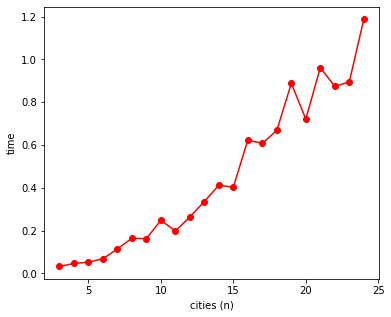

In [5]:
# Determine size of the graph
plt.rcParams["figure.figsize"] = (6,5)
# Plot data
plt.plot(pnts_n, pnts_t, 'ro-')
# Label x and y axis
plt.ylabel('time')
plt.xlabel('cities (n)')
# show graph
plt.show()

# Discussion:
As you can see the GRASP search shows a running time of 0(n^2) which shows it grows in polynomial time

# Ant Colony

In [6]:
import random as rn
import numpy as np
from numpy.random import choice as np_choice

class AntColony(object):

    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        """
        Args:
            distances (2D numpy.array): Square matrix of distances. Diagonal is assumed to be np.inf.
            n_ants (int): Number of ants running per iteration
            n_best (int): Number of best ants who deposit pheromone
            n_iteration (int): Number of iterations
            decay (float): Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
            alpha (int or float): exponenet on pheromone, higher alpha gives pheromone more weight. Default=1
            beta (int or float): exponent on distance, higher beta give distance more weight. Default=1

        Example:
            ant_colony = AntColony(german_distances, 100, 20, 2000, 0.95, alpha=1, beta=2)          
        """
        self.distances  = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            print (shortest_path)
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone * self.decay            
        return all_time_shortest_path

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start)) # going back to where we started    
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0]
        return move

# Code used from:
# https://github.com/Akavall/AntColonyOptimization

In [ ]:
pnts_n = []
pnts_t = []

n = 3
s = 1
t0 = t1 = 0

while t1-t0<1:
    G = random_symmetric_graph(n,s)
    ant_colony = AntColony(np.array(G), 2, 2, 100, 0.95, alpha=1, beta=1)
    t0 = time()
    shortest_path = ant_colony.run()
    t1 = time ()
    # record time
    print("node, time: " + f"{n}\t{t1-t0}" )
    pnts_n.append( n )
    pnts_t.append( t1-t0)
    n += 1

([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 2), (2, 1), (1, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 2), (2, 1), (1, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 2), (2, 1), (1, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 2), (2, 0)], 189.0)
([(0, 1), (1, 

([(0, 4), (4, 2), (2, 3), (3, 1), (1, 0)], 199.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 2), (2, 1), (1, 3), (3, 0)], 214.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 2), (2, 1), (1, 3), (3, 0)], 214.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 2), (2, 1), (1, 3), (3, 0)], 214.0)
([(0, 4), (4, 2), (2, 1), (1, 3), (3, 0)], 214.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 3), (3, 1), (1, 2), (2, 0)], 192.0)
([(0, 4), (4, 2), (2, 1), (1, 3), (3, 0)], 214.0)


([(0, 1), (1, 4), (4, 3), (3, 2), (2, 5), (5, 6), (6, 0)], 257.0)
([(0, 4), (4, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 236.0)
([(0, 4), (4, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 236.0)
([(0, 4), (4, 3), (3, 6), (6, 2), (2, 5), (5, 1), (1, 0)], 224.0)
([(0, 4), (4, 3), (3, 5), (5, 2), (2, 6), (6, 1), (1, 0)], 241.0)
([(0, 4), (4, 3), (3, 5), (5, 2), (2, 6), (6, 1), (1, 0)], 241.0)
([(0, 4), (4, 3), (3, 6), (6, 2), (2, 5), (5, 1), (1, 0)], 224.0)
([(0, 6), (6, 2), (2, 4), (4, 3), (3, 5), (5, 1), (1, 0)], 239.0)
([(0, 4), (4, 3), (3, 5), (5, 2), (2, 6), (6, 1), (1, 0)], 241.0)
([(0, 4), (4, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 236.0)
([(0, 4), (4, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 236.0)
([(0, 4), (4, 3), (3, 5), (5, 2), (2, 6), (6, 1), (1, 0)], 241.0)
([(0, 4), (4, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 236.0)
([(0, 4), (4, 3), (3, 6), (6, 2), (2, 5), (5, 1), (1, 0)], 224.0)
([(0, 4), (4, 3), (3, 5), (5, 2), (2, 1), (1, 6), (6, 0)], 240.0)
([(0, 4), 

([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 6), (6, 1), (1, 0)], 222.0)
([(0, 4), (4, 5), (5, 2), (2, 3), (3, 7), (7, 1), (1, 6), (6, 0)], 209.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 211.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 211.0)
([(0, 4), (4, 7), (7, 3), (3, 5), (5, 2), (2, 6), (6, 1), (1, 0)], 264.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 6), (6, 1), (1, 0)], 222.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 6), (6, 1), (1, 0)], 222.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 211.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 211.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 211.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 211.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 6), (6, 1), (1, 0)], 222.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 5), (5, 1), (1, 6), (6, 0)], 211.0)
([(0, 4), (4, 7), (7, 3), (3, 2), (2, 

([(0, 4), (4, 6), (6, 5), (5, 1), (1, 8), (8, 3), (3, 2), (2, 7), (7, 9), (9, 0)], 203.0)
([(0, 4), (4, 7), (7, 2), (2, 9), (9, 6), (6, 5), (5, 8), (8, 1), (1, 3), (3, 0)], 352.0)
([(0, 4), (4, 6), (6, 5), (5, 9), (9, 7), (7, 2), (2, 1), (1, 8), (8, 3), (3, 0)], 249.0)
([(0, 4), (4, 6), (6, 5), (5, 1), (1, 8), (8, 3), (3, 9), (9, 7), (7, 2), (2, 0)], 203.0)
([(0, 2), (2, 7), (7, 4), (4, 6), (6, 5), (5, 1), (1, 8), (8, 3), (3, 9), (9, 0)], 227.0)
([(0, 4), (4, 6), (6, 5), (5, 9), (9, 7), (7, 2), (2, 1), (1, 8), (8, 3), (3, 0)], 249.0)
([(0, 6), (6, 5), (5, 4), (4, 7), (7, 2), (2, 1), (1, 8), (8, 3), (3, 9), (9, 0)], 205.0)
([(0, 4), (4, 7), (7, 2), (2, 1), (1, 8), (8, 3), (3, 9), (9, 6), (6, 5), (5, 0)], 173.0)
([(0, 4), (4, 6), (6, 5), (5, 9), (9, 3), (3, 8), (8, 1), (1, 7), (7, 2), (2, 0)], 238.0)
([(0, 6), (6, 9), (9, 8), (8, 1), (1, 5), (5, 4), (4, 7), (7, 2), (2, 3), (3, 0)], 312.0)
([(0, 4), (4, 6), (6, 5), (5, 1), (1, 8), (8, 3), (3, 7), (7, 2), (2, 9), (9, 0)], 252.0)
([(0, 4), 

([(0, 4), (4, 6), (6, 9), (9, 3), (3, 8), (8, 2), (2, 5), (5, 7), (7, 1), (1, 10), (10, 0)], 272.0)
([(0, 4), (4, 6), (6, 10), (10, 2), (2, 5), (5, 7), (7, 1), (1, 9), (9, 3), (3, 8), (8, 0)], 241.0)
([(0, 4), (4, 6), (6, 10), (10, 2), (2, 5), (5, 7), (7, 1), (1, 8), (8, 3), (3, 9), (9, 0)], 195.0)
([(0, 4), (4, 6), (6, 10), (10, 2), (2, 5), (5, 7), (7, 1), (1, 3), (3, 8), (8, 9), (9, 0)], 219.0)
([(0, 4), (4, 6), (6, 8), (8, 3), (3, 9), (9, 5), (5, 2), (2, 10), (10, 1), (1, 7), (7, 0)], 288.0)
([(0, 4), (4, 6), (6, 10), (10, 2), (2, 5), (5, 7), (7, 1), (1, 8), (8, 3), (3, 9), (9, 0)], 195.0)
([(0, 4), (4, 6), (6, 10), (10, 9), (9, 3), (3, 8), (8, 2), (2, 5), (5, 7), (7, 1), (1, 0)], 169.0)
([(0, 4), (4, 6), (6, 10), (10, 9), (9, 3), (3, 8), (8, 2), (2, 5), (5, 7), (7, 1), (1, 0)], 169.0)
([(0, 4), (4, 6), (6, 10), (10, 2), (2, 5), (5, 7), (7, 1), (1, 9), (9, 3), (3, 8), (8, 0)], 241.0)
([(0, 4), (4, 6), (6, 10), (10, 2), (2, 5), (5, 7), (7, 1), (1, 8), (8, 3), (3, 9), (9, 0)], 195.0)


([(0, 4), (4, 8), (8, 7), (7, 2), (2, 3), (3, 9), (9, 5), (5, 11), (11, 10), (10, 1), (1, 6), (6, 0)], 306.0)
([(0, 4), (4, 8), (8, 7), (7, 9), (9, 3), (3, 2), (2, 10), (10, 11), (11, 6), (6, 1), (1, 5), (5, 0)], 241.0)
([(0, 4), (4, 8), (8, 7), (7, 1), (1, 6), (6, 3), (3, 2), (2, 10), (10, 11), (11, 9), (9, 5), (5, 0)], 206.0)
([(0, 4), (4, 8), (8, 7), (7, 9), (9, 3), (3, 2), (2, 10), (10, 11), (11, 5), (5, 6), (6, 1), (1, 0)], 212.0)
([(0, 4), (4, 8), (8, 7), (7, 9), (9, 3), (3, 2), (2, 10), (10, 11), (11, 5), (5, 6), (6, 1), (1, 0)], 212.0)
([(0, 4), (4, 8), (8, 7), (7, 10), (10, 2), (2, 3), (3, 6), (6, 1), (1, 9), (9, 5), (5, 11), (11, 0)], 333.0)
([(0, 4), (4, 8), (8, 7), (7, 1), (1, 6), (6, 3), (3, 2), (2, 10), (10, 11), (11, 5), (5, 9), (9, 0)], 223.0)
([(0, 4), (4, 8), (8, 7), (7, 1), (1, 6), (6, 3), (3, 2), (2, 10), (10, 11), (11, 9), (9, 5), (5, 0)], 206.0)
([(0, 4), (4, 8), (8, 7), (7, 9), (9, 3), (3, 2), (2, 10), (10, 11), (11, 5), (5, 6), (6, 1), (1, 0)], 212.0)
([(0, 4), 

([(0, 4), (4, 8), (8, 2), (2, 11), (11, 1), (1, 5), (5, 12), (12, 3), (3, 6), (6, 10), (10, 7), (7, 9), (9, 0)], 222.0)
([(0, 4), (4, 6), (6, 3), (3, 12), (12, 5), (5, 1), (1, 11), (11, 2), (2, 10), (10, 7), (7, 9), (9, 8), (8, 0)], 304.0)
([(0, 4), (4, 6), (6, 3), (3, 12), (12, 5), (5, 1), (1, 11), (11, 2), (2, 10), (10, 7), (7, 9), (9, 8), (8, 0)], 304.0)
([(0, 4), (4, 11), (11, 1), (1, 5), (5, 12), (12, 3), (3, 6), (6, 10), (10, 7), (7, 9), (9, 8), (8, 2), (2, 0)], 300.0)
([(0, 4), (4, 6), (6, 3), (3, 12), (12, 5), (5, 1), (1, 11), (11, 2), (2, 10), (10, 7), (7, 9), (9, 8), (8, 0)], 304.0)
([(0, 4), (4, 6), (6, 3), (3, 12), (12, 5), (5, 1), (1, 11), (11, 2), (2, 10), (10, 7), (7, 9), (9, 8), (8, 0)], 304.0)
([(0, 4), (4, 2), (2, 10), (10, 7), (7, 9), (9, 12), (12, 5), (5, 1), (1, 11), (11, 8), (8, 3), (3, 6), (6, 0)], 306.0)
([(0, 4), (4, 11), (11, 2), (2, 10), (10, 7), (7, 9), (9, 12), (12, 5), (5, 1), (1, 3), (3, 6), (6, 8), (8, 0)], 317.0)
([(0, 4), (4, 2), (2, 10), (10, 7), (7, 

([(0, 4), (4, 1), (1, 10), (10, 2), (2, 13), (13, 11), (11, 9), (9, 3), (3, 6), (6, 12), (12, 8), (8, 5), (5, 7), (7, 0)], 359.0)
([(0, 4), (4, 1), (1, 10), (10, 2), (2, 13), (13, 11), (11, 9), (9, 3), (3, 6), (6, 8), (8, 5), (5, 7), (7, 12), (12, 0)], 249.0)
([(0, 4), (4, 1), (1, 10), (10, 2), (2, 13), (13, 11), (11, 9), (9, 3), (3, 6), (6, 8), (8, 12), (12, 7), (7, 5), (5, 0)], 244.0)
([(0, 4), (4, 1), (1, 10), (10, 2), (2, 13), (13, 11), (11, 9), (9, 3), (3, 6), (6, 8), (8, 5), (5, 7), (7, 12), (12, 0)], 249.0)
([(0, 4), (4, 1), (1, 10), (10, 2), (2, 13), (13, 11), (11, 9), (9, 3), (3, 6), (6, 8), (8, 12), (12, 5), (5, 7), (7, 0)], 274.0)
([(0, 4), (4, 1), (1, 10), (10, 2), (2, 13), (13, 11), (11, 9), (9, 3), (3, 5), (5, 7), (7, 12), (12, 8), (8, 6), (6, 0)], 287.0)
([(0, 4), (4, 1), (1, 10), (10, 2), (2, 13), (13, 8), (8, 9), (9, 3), (3, 11), (11, 5), (5, 7), (7, 12), (12, 6), (6, 0)], 291.0)
([(0, 4), (4, 1), (1, 10), (10, 2), (2, 13), (13, 11), (11, 9), (9, 3), (3, 6), (6, 8), (8

([(0, 4), (4, 11), (11, 2), (2, 7), (7, 13), (13, 10), (10, 5), (5, 6), (6, 3), (3, 1), (1, 9), (9, 8), (8, 14), (14, 12), (12, 0)], 219.0)
([(0, 4), (4, 11), (11, 2), (2, 7), (7, 13), (13, 10), (10, 5), (5, 6), (6, 3), (3, 1), (1, 9), (9, 8), (8, 14), (14, 12), (12, 0)], 219.0)
([(0, 5), (5, 6), (6, 3), (3, 1), (1, 9), (9, 8), (8, 2), (2, 7), (7, 13), (13, 10), (10, 4), (4, 11), (11, 14), (14, 12), (12, 0)], 236.0)
([(0, 4), (4, 11), (11, 2), (2, 7), (7, 13), (13, 10), (10, 1), (1, 9), (9, 8), (8, 14), (14, 12), (12, 6), (6, 3), (3, 5), (5, 0)], 356.0)
([(0, 4), (4, 11), (11, 2), (2, 7), (7, 13), (13, 10), (10, 5), (5, 6), (6, 3), (3, 1), (1, 9), (9, 8), (8, 14), (14, 12), (12, 0)], 219.0)
([(0, 6), (6, 3), (3, 1), (1, 9), (9, 8), (8, 2), (2, 7), (7, 13), (13, 10), (10, 5), (5, 4), (4, 11), (11, 14), (14, 12), (12, 0)], 236.0)
([(0, 4), (4, 11), (11, 2), (2, 7), (7, 13), (13, 10), (10, 3), (3, 1), (1, 9), (9, 8), (8, 14), (14, 12), (12, 6), (6, 5), (5, 0)], 243.0)
([(0, 4), (4, 11), (

([(0, 7), (7, 4), (4, 12), (12, 9), (9, 2), (2, 5), (5, 15), (15, 10), (10, 3), (3, 6), (6, 14), (14, 8), (8, 1), (1, 13), (13, 11), (11, 0)], 405.0)
([(0, 13), (13, 11), (11, 1), (1, 8), (8, 6), (6, 14), (14, 15), (15, 10), (10, 3), (3, 2), (2, 5), (5, 12), (12, 9), (9, 7), (7, 4), (4, 0)], 388.0)
([(0, 13), (13, 11), (11, 1), (1, 8), (8, 14), (14, 6), (6, 2), (2, 5), (5, 12), (12, 9), (9, 10), (10, 15), (15, 4), (4, 7), (7, 3), (3, 0)], 447.0)
([(0, 1), (1, 8), (8, 14), (14, 6), (6, 5), (5, 2), (2, 4), (4, 7), (7, 9), (9, 12), (12, 3), (3, 13), (13, 11), (11, 15), (15, 10), (10, 0)], 451.0)
([(0, 4), (4, 7), (7, 9), (9, 2), (2, 5), (5, 6), (6, 14), (14, 8), (8, 1), (1, 13), (13, 11), (11, 3), (3, 15), (15, 10), (10, 12), (12, 0)], 427.0)
([(0, 4), (4, 7), (7, 6), (6, 14), (14, 3), (3, 5), (5, 2), (2, 15), (15, 10), (10, 12), (12, 13), (13, 11), (11, 1), (1, 8), (8, 9), (9, 0)], 442.0)
([(0, 4), (4, 7), (7, 8), (8, 1), (1, 2), (2, 5), (5, 6), (6, 14), (14, 9), (9, 12), (12, 3), (3, 10

([(0, 4), (4, 7), (7, 13), (13, 11), (11, 14), (14, 8), (8, 1), (1, 2), (2, 9), (9, 12), (12, 3), (3, 5), (5, 6), (6, 10), (10, 15), (15, 0)], 320.0)
([(0, 4), (4, 7), (7, 11), (11, 13), (13, 1), (1, 8), (8, 14), (14, 6), (6, 2), (2, 9), (9, 12), (12, 3), (3, 10), (10, 15), (15, 5), (5, 0)], 262.0)
([(0, 4), (4, 7), (7, 3), (3, 12), (12, 9), (9, 2), (2, 5), (5, 6), (6, 14), (14, 8), (8, 1), (1, 15), (15, 10), (10, 11), (11, 13), (13, 0)], 254.0)
([(0, 4), (4, 7), (7, 13), (13, 11), (11, 14), (14, 6), (6, 2), (2, 9), (9, 12), (12, 3), (3, 10), (10, 15), (15, 1), (1, 8), (8, 5), (5, 0)], 261.0)
([(0, 4), (4, 7), (7, 13), (13, 11), (11, 3), (3, 14), (14, 6), (6, 2), (2, 9), (9, 12), (12, 8), (8, 1), (1, 15), (15, 10), (10, 5), (5, 0)], 379.0)
([(0, 4), (4, 7), (7, 10), (10, 15), (15, 2), (2, 9), (9, 12), (12, 3), (3, 5), (5, 6), (6, 14), (14, 8), (8, 1), (1, 13), (13, 11), (11, 0)], 301.0)
([(0, 4), (4, 7), (7, 13), (13, 11), (11, 5), (5, 2), (2, 9), (9, 12), (12, 3), (3, 10), (10, 15), (

([(0, 16), (16, 1), (1, 7), (7, 2), (2, 3), (3, 15), (15, 10), (10, 8), (8, 6), (6, 14), (14, 11), (11, 9), (9, 13), (13, 5), (5, 12), (12, 4), (4, 0)], 294.0)
([(0, 16), (16, 1), (1, 7), (7, 2), (2, 3), (3, 15), (15, 10), (10, 8), (8, 6), (6, 5), (5, 14), (14, 11), (11, 9), (9, 13), (13, 12), (12, 4), (4, 0)], 294.0)
([(0, 16), (16, 1), (1, 7), (7, 2), (2, 3), (3, 15), (15, 10), (10, 8), (8, 6), (6, 4), (4, 12), (12, 13), (13, 9), (9, 11), (11, 14), (14, 5), (5, 0)], 336.0)
([(0, 16), (16, 1), (1, 7), (7, 2), (2, 3), (3, 15), (15, 10), (10, 8), (8, 6), (6, 5), (5, 12), (12, 4), (4, 14), (14, 11), (11, 9), (9, 13), (13, 0)], 258.0)
([(0, 16), (16, 1), (1, 7), (7, 2), (2, 3), (3, 15), (15, 10), (10, 8), (8, 6), (6, 13), (13, 9), (9, 11), (11, 14), (14, 4), (4, 12), (12, 5), (5, 0)], 253.0)
([(0, 16), (16, 1), (1, 7), (7, 2), (2, 3), (3, 15), (15, 10), (10, 8), (8, 6), (6, 13), (13, 9), (9, 11), (11, 14), (14, 4), (4, 12), (12, 5), (5, 0)], 253.0)
([(0, 16), (16, 1), (1, 7), (7, 2), (2, 

([(0, 16), (16, 9), (9, 13), (13, 5), (5, 2), (2, 6), (6, 1), (1, 17), (17, 3), (3, 12), (12, 15), (15, 11), (11, 7), (7, 4), (4, 8), (8, 10), (10, 14), (14, 0)], 267.0)
([(0, 16), (16, 1), (1, 6), (6, 9), (9, 13), (13, 5), (5, 2), (2, 11), (11, 10), (10, 8), (8, 12), (12, 15), (15, 4), (4, 7), (7, 3), (3, 17), (17, 14), (14, 0)], 383.0)
([(0, 16), (16, 1), (1, 6), (6, 17), (17, 3), (3, 12), (12, 15), (15, 9), (9, 13), (13, 5), (5, 2), (2, 11), (11, 7), (7, 8), (8, 10), (10, 14), (14, 4), (4, 0)], 280.0)
([(0, 16), (16, 1), (1, 6), (6, 17), (17, 3), (3, 12), (12, 15), (15, 13), (13, 5), (5, 2), (2, 11), (11, 7), (7, 4), (4, 8), (8, 10), (10, 14), (14, 9), (9, 0)], 301.0)
([(0, 16), (16, 1), (1, 6), (6, 9), (9, 13), (13, 5), (5, 2), (2, 11), (11, 7), (7, 15), (15, 12), (12, 3), (3, 17), (17, 10), (10, 8), (8, 4), (4, 14), (14, 0)], 290.0)
([(0, 16), (16, 1), (1, 6), (6, 3), (3, 12), (12, 15), (15, 14), (14, 9), (9, 13), (13, 5), (5, 2), (2, 11), (11, 7), (7, 4), (4, 8), (8, 10), (10, 17

([(0, 16), (16, 10), (10, 3), (3, 2), (2, 9), (9, 12), (12, 7), (7, 5), (5, 8), (8, 1), (1, 11), (11, 13), (13, 4), (4, 18), (18, 17), (17, 6), (6, 15), (15, 14), (14, 0)], 495.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 13), (13, 12), (12, 7), (7, 15), (15, 6), (6, 11), (11, 18), (18, 17), (17, 10), (10, 2), (2, 3), (3, 9), (9, 4), (4, 0)], 371.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 13), (13, 3), (3, 2), (2, 9), (9, 12), (12, 7), (7, 15), (15, 6), (6, 17), (17, 18), (18, 4), (4, 10), (10, 11), (11, 0)], 408.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 12), (12, 7), (7, 15), (15, 6), (6, 17), (17, 18), (18, 3), (3, 2), (2, 9), (9, 13), (13, 11), (11, 10), (10, 4), (4, 0)], 310.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 12), (12, 7), (7, 15), (15, 6), (6, 11), (11, 2), (2, 9), (9, 3), (3, 13), (13, 4), (4, 17), (17, 18), (18, 10), (10, 0)], 405.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 17), (17, 18), (18, 3), (3, 2), (2, 9), (9, 12), (

([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 13), (13, 12), (12, 7), (7, 15), (15, 6), (6, 11), (11, 10), (10, 17), (17, 18), (18, 3), (3, 2), (2, 9), (9, 4), (4, 0)], 300.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 13), (13, 3), (3, 2), (2, 9), (9, 12), (12, 7), (7, 15), (15, 6), (6, 11), (11, 17), (17, 18), (18, 4), (4, 10), (10, 0)], 368.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 15), (15, 4), (4, 13), (13, 3), (3, 2), (2, 9), (9, 17), (17, 18), (18, 12), (12, 7), (7, 10), (10, 11), (11, 6), (6, 0)], 332.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 12), (12, 7), (7, 15), (15, 6), (6, 11), (11, 13), (13, 3), (3, 2), (2, 9), (9, 4), (4, 10), (10, 17), (17, 18), (18, 0)], 373.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 12), (12, 7), (7, 2), (2, 9), (9, 3), (3, 18), (18, 17), (17, 10), (10, 11), (11, 13), (13, 4), (4, 15), (15, 6), (6, 0)], 317.0)
([(0, 16), (16, 14), (14, 1), (1, 5), (5, 8), (8, 13), (13, 11), (11, 17), (17, 18), (18, 3), (3, 2)

([(0, 16), (16, 17), (17, 6), (6, 3), (3, 10), (10, 8), (8, 13), (13, 12), (12, 1), (1, 4), (4, 11), (11, 14), (14, 2), (2, 7), (7, 19), (19, 15), (15, 9), (9, 18), (18, 5), (5, 0)], 387.0)
([(0, 16), (16, 19), (19, 7), (7, 2), (2, 4), (4, 1), (1, 14), (14, 15), (15, 9), (9, 6), (6, 3), (3, 10), (10, 8), (8, 13), (13, 12), (12, 18), (18, 5), (5, 17), (17, 11), (11, 0)], 440.0)
([(0, 16), (16, 17), (17, 6), (6, 3), (3, 10), (10, 8), (8, 13), (13, 12), (12, 2), (2, 7), (7, 19), (19, 11), (11, 5), (5, 18), (18, 1), (1, 4), (4, 9), (9, 15), (15, 14), (14, 0)], 375.0)
([(0, 16), (16, 19), (19, 7), (7, 2), (2, 11), (11, 3), (3, 10), (10, 8), (8, 5), (5, 18), (18, 1), (1, 4), (4, 17), (17, 6), (6, 9), (9, 15), (15, 13), (13, 12), (12, 14), (14, 0)], 312.0)
([(0, 16), (16, 19), (19, 7), (7, 2), (2, 4), (4, 1), (1, 18), (18, 15), (15, 9), (9, 6), (6, 3), (3, 10), (10, 8), (8, 13), (13, 12), (12, 11), (11, 5), (5, 14), (14, 17), (17, 0)], 421.0)
([(0, 16), (16, 19), (19, 7), (7, 2), (2, 13), (13

([(0, 16), (16, 13), (13, 18), (18, 10), (10, 9), (9, 14), (14, 1), (1, 3), (3, 12), (12, 7), (7, 20), (20, 2), (2, 5), (5, 17), (17, 8), (8, 6), (6, 11), (11, 4), (4, 15), (15, 19), (19, 0)], 379.0)
([(0, 16), (16, 13), (13, 4), (4, 5), (5, 2), (2, 20), (20, 7), (7, 12), (12, 19), (19, 15), (15, 18), (18, 10), (10, 9), (9, 6), (6, 11), (11, 17), (17, 8), (8, 1), (1, 3), (3, 14), (14, 0)], 304.0)
([(0, 16), (16, 13), (13, 4), (4, 20), (20, 2), (2, 5), (5, 17), (17, 8), (8, 3), (3, 6), (6, 11), (11, 18), (18, 10), (10, 7), (7, 12), (12, 19), (19, 15), (15, 9), (9, 14), (14, 1), (1, 0)], 397.0)
([(0, 16), (16, 13), (13, 18), (18, 10), (10, 9), (9, 14), (14, 1), (1, 3), (3, 12), (12, 7), (7, 8), (8, 6), (6, 11), (11, 17), (17, 15), (15, 20), (20, 2), (2, 5), (5, 4), (4, 19), (19, 0)], 410.0)
([(0, 16), (16, 13), (13, 4), (4, 3), (3, 1), (1, 17), (17, 8), (8, 12), (12, 7), (7, 14), (14, 15), (15, 20), (20, 2), (2, 5), (5, 11), (11, 18), (18, 10), (10, 9), (9, 6), (6, 19), (19, 0)], 532.0)


([(0, 16), (16, 13), (13, 18), (18, 10), (10, 9), (9, 7), (7, 12), (12, 19), (19, 15), (15, 20), (20, 2), (2, 5), (5, 17), (17, 8), (8, 6), (6, 11), (11, 14), (14, 1), (1, 3), (3, 4), (4, 0)], 284.0)
([(0, 16), (16, 13), (13, 18), (18, 10), (10, 9), (9, 14), (14, 1), (1, 3), (3, 7), (7, 12), (12, 19), (19, 15), (15, 20), (20, 2), (2, 5), (5, 17), (17, 8), (8, 6), (6, 11), (11, 4), (4, 0)], 256.0)
([(0, 16), (16, 13), (13, 18), (18, 10), (10, 9), (9, 4), (4, 5), (5, 2), (2, 20), (20, 15), (15, 19), (19, 12), (12, 7), (7, 11), (11, 17), (17, 8), (8, 3), (3, 1), (1, 14), (14, 6), (6, 0)], 293.0)
([(0, 16), (16, 13), (13, 18), (18, 10), (10, 9), (9, 7), (7, 12), (12, 19), (19, 15), (15, 20), (20, 2), (2, 5), (5, 17), (17, 8), (8, 3), (3, 1), (1, 14), (14, 6), (6, 11), (11, 4), (4, 0)], 254.0)
([(0, 16), (16, 13), (13, 18), (18, 10), (10, 9), (9, 14), (14, 1), (1, 3), (3, 12), (12, 7), (7, 2), (2, 20), (20, 15), (15, 19), (19, 5), (5, 17), (17, 8), (8, 6), (6, 11), (11, 4), (4, 0)], 300.0)


([(0, 16), (16, 1), (1, 12), (12, 13), (13, 11), (11, 20), (20, 21), (21, 6), (6, 7), (7, 17), (17, 18), (18, 2), (2, 3), (3, 4), (4, 9), (9, 8), (8, 5), (5, 14), (14, 19), (19, 15), (15, 10), (10, 0)], 360.0)
([(0, 16), (16, 1), (1, 2), (2, 18), (18, 6), (6, 19), (19, 9), (9, 8), (8, 5), (5, 20), (20, 21), (21, 17), (17, 12), (12, 13), (13, 11), (11, 4), (4, 3), (3, 15), (15, 7), (7, 10), (10, 14), (14, 0)], 423.0)
([(0, 16), (16, 10), (10, 13), (13, 12), (12, 1), (1, 2), (2, 18), (18, 17), (17, 7), (7, 6), (6, 19), (19, 9), (9, 8), (8, 5), (5, 3), (3, 4), (4, 11), (11, 20), (20, 21), (21, 15), (15, 14), (14, 0)], 344.0)
([(0, 16), (16, 1), (1, 2), (2, 18), (18, 17), (17, 10), (10, 7), (7, 6), (6, 19), (19, 9), (9, 8), (8, 5), (5, 20), (20, 11), (11, 13), (13, 12), (12, 21), (21, 15), (15, 14), (14, 4), (4, 3), (3, 0)], 441.0)
([(0, 16), (16, 1), (1, 12), (12, 13), (13, 11), (11, 20), (20, 21), (21, 6), (6, 19), (19, 9), (9, 8), (8, 5), (5, 14), (14, 7), (7, 15), (15, 10), (10, 17), (

([(0, 16), (16, 1), (1, 2), (2, 18), (18, 11), (11, 20), (20, 21), (21, 12), (12, 13), (13, 8), (8, 9), (9, 4), (4, 10), (10, 19), (19, 6), (6, 7), (7, 17), (17, 5), (5, 3), (3, 14), (14, 15), (15, 0)], 488.0)
([(0, 16), (16, 1), (1, 2), (2, 18), (18, 11), (11, 20), (20, 21), (21, 13), (13, 12), (12, 19), (19, 9), (9, 8), (8, 5), (5, 14), (14, 4), (4, 3), (3, 15), (15, 6), (6, 7), (7, 10), (10, 17), (17, 0)], 360.0)
([(0, 16), (16, 1), (1, 2), (2, 18), (18, 11), (11, 20), (20, 21), (21, 13), (13, 12), (12, 19), (19, 9), (9, 8), (8, 5), (5, 3), (3, 4), (4, 17), (17, 10), (10, 7), (7, 6), (6, 15), (15, 14), (14, 0)], 349.0)
([(0, 16), (16, 1), (1, 2), (2, 18), (18, 12), (12, 13), (13, 11), (11, 20), (20, 21), (21, 6), (6, 19), (19, 9), (9, 8), (8, 5), (5, 3), (3, 4), (4, 15), (15, 7), (7, 10), (10, 17), (17, 14), (14, 0)], 432.0)
([(0, 16), (16, 1), (1, 2), (2, 18), (18, 17), (17, 7), (7, 6), (6, 19), (19, 9), (9, 8), (8, 5), (5, 20), (20, 21), (21, 12), (12, 13), (13, 11), (11, 4), (4, 

([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 21), (21, 1), (1, 15), (15, 7), (7, 19), (19, 4), (4, 5), (5, 17), (17, 14), (14, 12), (12, 11), (11, 8), (8, 3), (3, 6), (6, 13), (13, 0)], 355.0)
([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 21), (21, 1), (1, 15), (15, 7), (7, 5), (5, 4), (4, 12), (12, 17), (17, 11), (11, 8), (8, 3), (3, 6), (6, 13), (13, 19), (19, 14), (14, 0)], 230.0)
([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 13), (13, 6), (6, 3), (3, 21), (21, 1), (1, 15), (15, 7), (7, 5), (5, 4), (4, 12), (12, 17), (17, 11), (11, 8), (8, 14), (14, 19), (19, 0)], 361.0)
([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 21), (21, 1), (1, 15), (15, 7), (7, 19), (19, 14), (14, 11), (11, 8), (8, 3), (3, 17), (17, 5), (5, 4), (4, 12), (12, 13), (13, 6), (6, 0)], 269.0)
([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 21), (21, 1), (1, 15), (15, 7), (7, 5), (5, 17),

([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 13), (13, 6), (6, 3), (3, 15), (15, 7), (7, 5), (5, 17), (17, 11), (11, 1), (1, 21), (21, 8), (8, 19), (19, 14), (14, 12), (12, 4), (4, 0)], 303.0)
([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 21), (21, 1), (1, 15), (15, 7), (7, 5), (5, 4), (4, 12), (12, 14), (14, 19), (19, 11), (11, 8), (8, 17), (17, 3), (3, 6), (6, 13), (13, 0)], 296.0)
([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 21), (21, 1), (1, 15), (15, 7), (7, 5), (5, 4), (4, 12), (12, 14), (14, 17), (17, 11), (11, 8), (8, 3), (3, 6), (6, 13), (13, 19), (19, 0)], 305.0)
([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 13), (13, 6), (6, 3), (3, 15), (15, 7), (7, 19), (19, 14), (14, 12), (12, 1), (1, 11), (11, 8), (8, 21), (21, 4), (4, 5), (5, 17), (17, 0)], 316.0)
([(0, 22), (22, 10), (10, 9), (9, 18), (18, 16), (16, 2), (2, 20), (20, 21), (21, 1), (1, 15), (15, 7), (7, 5), (5, 4), 

([(0, 22), (22, 23), (23, 9), (9, 19), (19, 16), (16, 11), (11, 1), (1, 20), (20, 3), (3, 14), (14, 2), (2, 18), (18, 7), (7, 8), (8, 15), (15, 4), (4, 17), (17, 12), (12, 10), (10, 5), (5, 21), (21, 13), (13, 6), (6, 0)], 321.0)
([(0, 22), (22, 23), (23, 9), (9, 19), (19, 16), (16, 4), (4, 20), (20, 3), (3, 13), (13, 21), (21, 18), (18, 7), (7, 8), (8, 15), (15, 6), (6, 14), (14, 2), (2, 5), (5, 12), (12, 17), (17, 10), (10, 1), (1, 11), (11, 0)], 426.0)
([(0, 22), (22, 23), (23, 9), (9, 19), (19, 16), (16, 4), (4, 20), (20, 3), (3, 13), (13, 21), (21, 17), (17, 14), (14, 1), (1, 11), (11, 10), (10, 5), (5, 12), (12, 6), (6, 7), (7, 8), (8, 15), (15, 18), (18, 2), (2, 0)], 324.0)
([(0, 22), (22, 23), (23, 9), (9, 1), (1, 14), (14, 2), (2, 18), (18, 7), (7, 8), (8, 15), (15, 3), (3, 20), (20, 21), (21, 13), (13, 11), (11, 12), (12, 10), (10, 5), (5, 19), (19, 16), (16, 4), (4, 6), (6, 17), (17, 0)], 441.0)
([(0, 22), (22, 23), (23, 9), (9, 1), (1, 14), (14, 2), (2, 18), (18, 7), (7, 8)

([(0, 22), (22, 23), (23, 9), (9, 1), (1, 14), (14, 2), (2, 18), (18, 7), (7, 8), (8, 15), (15, 4), (4, 16), (16, 19), (19, 20), (20, 3), (3, 12), (12, 10), (10, 5), (5, 21), (21, 13), (13, 11), (11, 17), (17, 6), (6, 0)], 341.0)
([(0, 22), (22, 23), (23, 9), (9, 1), (1, 14), (14, 2), (2, 18), (18, 21), (21, 13), (13, 11), (11, 16), (16, 19), (19, 20), (20, 3), (3, 12), (12, 10), (10, 5), (5, 6), (6, 7), (7, 8), (8, 15), (15, 4), (4, 17), (17, 0)], 341.0)
([(0, 22), (22, 23), (23, 9), (9, 1), (1, 14), (14, 2), (2, 18), (18, 7), (7, 8), (8, 15), (15, 10), (10, 5), (5, 12), (12, 17), (17, 21), (21, 13), (13, 11), (11, 16), (16, 19), (19, 20), (20, 3), (3, 6), (6, 4), (4, 0)], 317.0)
([(0, 22), (22, 23), (23, 9), (9, 19), (19, 16), (16, 4), (4, 20), (20, 3), (3, 12), (12, 10), (10, 5), (5, 21), (21, 13), (13, 11), (11, 1), (1, 14), (14, 2), (2, 18), (18, 7), (7, 8), (8, 15), (15, 6), (6, 17), (17, 0)], 296.0)
([(0, 22), (22, 23), (23, 9), (9, 1), (1, 14), (14, 2), (2, 18), (18, 21), (21, 

([(0, 22), (22, 19), (19, 5), (5, 7), (7, 23), (23, 17), (17, 21), (21, 12), (12, 2), (2, 16), (16, 9), (9, 14), (14, 20), (20, 10), (10, 1), (1, 13), (13, 15), (15, 8), (8, 24), (24, 4), (4, 18), (18, 6), (6, 11), (11, 3), (3, 0)], 356.0)
([(0, 22), (22, 19), (19, 5), (5, 7), (7, 23), (23, 17), (17, 21), (21, 12), (12, 2), (2, 3), (3, 8), (8, 15), (15, 24), (24, 4), (4, 18), (18, 6), (6, 11), (11, 16), (16, 9), (9, 14), (14, 20), (20, 13), (13, 1), (1, 10), (10, 0)], 414.0)
([(0, 22), (22, 19), (19, 5), (5, 7), (7, 23), (23, 17), (17, 21), (21, 12), (12, 2), (2, 16), (16, 9), (9, 14), (14, 20), (20, 3), (3, 24), (24, 4), (4, 11), (11, 8), (8, 15), (15, 13), (13, 10), (10, 1), (1, 6), (6, 18), (18, 0)], 409.0)
([(0, 22), (22, 19), (19, 5), (5, 7), (7, 23), (23, 17), (17, 21), (21, 12), (12, 2), (2, 16), (16, 9), (9, 14), (14, 20), (20, 10), (10, 1), (1, 13), (13, 15), (15, 8), (8, 18), (18, 6), (6, 3), (3, 24), (24, 4), (4, 11), (11, 0)], 354.0)
([(0, 22), (22, 19), (19, 5), (5, 7), (7

([(0, 22), (22, 19), (19, 5), (5, 7), (7, 23), (23, 17), (17, 21), (21, 12), (12, 2), (2, 16), (16, 9), (9, 14), (14, 20), (20, 10), (10, 1), (1, 13), (13, 15), (15, 8), (8, 3), (3, 11), (11, 24), (24, 4), (4, 18), (18, 6), (6, 0)], 295.0)
([(0, 22), (22, 19), (19, 5), (5, 7), (7, 23), (23, 17), (17, 21), (21, 12), (12, 2), (2, 8), (8, 1), (1, 13), (13, 9), (9, 14), (14, 20), (20, 10), (10, 15), (15, 24), (24, 4), (4, 18), (18, 6), (6, 11), (11, 3), (3, 16), (16, 0)], 333.0)
([(0, 22), (22, 19), (19, 5), (5, 7), (7, 23), (23, 17), (17, 21), (21, 12), (12, 2), (2, 16), (16, 9), (9, 14), (14, 20), (20, 10), (10, 1), (1, 13), (13, 15), (15, 8), (8, 18), (18, 6), (6, 3), (3, 24), (24, 4), (4, 11), (11, 0)], 354.0)
([(0, 22), (22, 19), (19, 5), (5, 7), (7, 23), (23, 17), (17, 21), (21, 12), (12, 2), (2, 16), (16, 9), (9, 14), (14, 20), (20, 11), (11, 24), (24, 4), (4, 18), (18, 6), (6, 3), (3, 8), (8, 15), (15, 13), (13, 1), (1, 10), (10, 0)], 367.0)
([(0, 22), (22, 19), (19, 5), (5, 7), (7

([(0, 22), (22, 11), (11, 20), (20, 21), (21, 15), (15, 23), (23, 8), (8, 1), (1, 12), (12, 6), (6, 3), (3, 14), (14, 5), (5, 10), (10, 2), (2, 19), (19, 9), (9, 18), (18, 17), (17, 13), (13, 25), (25, 16), (16, 7), (7, 24), (24, 4), (4, 0)], 321.0)
([(0, 22), (22, 11), (11, 20), (20, 21), (21, 15), (15, 23), (23, 8), (8, 1), (1, 12), (12, 6), (6, 2), (2, 10), (10, 5), (5, 14), (14, 19), (19, 16), (16, 7), (7, 24), (24, 18), (18, 9), (9, 13), (13, 25), (25, 4), (4, 3), (3, 17), (17, 0)], 475.0)
([(0, 22), (22, 11), (11, 20), (20, 21), (21, 8), (8, 17), (17, 13), (13, 25), (25, 7), (7, 16), (16, 24), (24, 10), (10, 2), (2, 18), (18, 1), (1, 12), (12, 6), (6, 3), (3, 14), (14, 5), (5, 19), (19, 9), (9, 15), (15, 23), (23, 4), (4, 0)], 330.0)
([(0, 22), (22, 11), (11, 20), (20, 21), (21, 15), (15, 23), (23, 8), (8, 1), (1, 12), (12, 6), (6, 3), (3, 14), (14, 5), (5, 10), (10, 2), (2, 4), (4, 16), (16, 7), (7, 24), (24, 18), (18, 9), (9, 13), (13, 17), (17, 25), (25, 19), (19, 0)], 425.0)


([(0, 22), (22, 11), (11, 20), (20, 21), (21, 15), (15, 23), (23, 8), (8, 1), (1, 12), (12, 6), (6, 16), (16, 7), (7, 24), (24, 25), (25, 10), (10, 2), (2, 4), (4, 14), (14, 5), (5, 13), (13, 17), (17, 19), (19, 18), (18, 9), (9, 3), (3, 0)], 460.0)
([(0, 22), (22, 11), (11, 20), (20, 21), (21, 15), (15, 23), (23, 8), (8, 17), (17, 13), (13, 25), (25, 19), (19, 14), (14, 5), (5, 10), (10, 2), (2, 4), (4, 12), (12, 6), (6, 16), (16, 7), (7, 24), (24, 18), (18, 9), (9, 1), (1, 3), (3, 0)], 353.0)
([(0, 22), (22, 11), (11, 20), (20, 21), (21, 15), (15, 23), (23, 8), (8, 1), (1, 12), (12, 6), (6, 16), (16, 7), (7, 24), (24, 18), (18, 9), (9, 19), (19, 14), (14, 5), (5, 4), (4, 3), (3, 13), (13, 17), (17, 10), (10, 2), (2, 25), (25, 0)], 514.0)
([(0, 22), (22, 11), (11, 20), (20, 21), (21, 15), (15, 23), (23, 8), (8, 1), (1, 12), (12, 6), (6, 16), (16, 7), (7, 24), (24, 18), (18, 9), (9, 13), (13, 17), (17, 14), (14, 5), (5, 10), (10, 2), (2, 4), (4, 25), (25, 19), (19, 3), (3, 0)], 455.0)


([(0, 22), (22, 17), (17, 14), (14, 19), (19, 13), (13, 8), (8, 15), (15, 18), (18, 4), (4, 16), (16, 26), (26, 5), (5, 9), (9, 7), (7, 1), (1, 6), (6, 10), (10, 24), (24, 20), (20, 25), (25, 12), (12, 2), (2, 3), (3, 11), (11, 23), (23, 21), (21, 0)], 355.0)
([(0, 22), (22, 17), (17, 14), (14, 19), (19, 13), (13, 8), (8, 15), (15, 18), (18, 4), (4, 16), (16, 26), (26, 5), (5, 9), (9, 7), (7, 1), (1, 11), (11, 3), (3, 12), (12, 25), (25, 20), (20, 24), (24, 10), (10, 21), (21, 23), (23, 2), (2, 6), (6, 0)], 327.0)
([(0, 22), (22, 17), (17, 14), (14, 11), (11, 1), (1, 7), (7, 9), (9, 5), (5, 26), (26, 10), (10, 24), (24, 20), (20, 13), (13, 19), (19, 21), (21, 23), (23, 15), (15, 18), (18, 4), (4, 16), (16, 2), (2, 8), (8, 12), (12, 25), (25, 3), (3, 6), (6, 0)], 361.0)
([(0, 22), (22, 17), (17, 14), (14, 19), (19, 13), (13, 8), (8, 15), (15, 18), (18, 4), (4, 16), (16, 26), (26, 5), (5, 9), (9, 7), (7, 1), (1, 11), (11, 3), (3, 23), (23, 21), (21, 10), (10, 24), (24, 20), (20, 25), (25

([(0, 22), (22, 17), (17, 14), (14, 19), (19, 13), (13, 8), (8, 15), (15, 18), (18, 4), (4, 16), (16, 26), (26, 5), (5, 9), (9, 7), (7, 1), (1, 11), (11, 3), (3, 23), (23, 21), (21, 6), (6, 10), (10, 24), (24, 20), (20, 25), (25, 12), (12, 2), (2, 0)], 324.0)
([(0, 22), (22, 17), (17, 14), (14, 11), (11, 1), (1, 7), (7, 9), (9, 5), (5, 26), (26, 16), (16, 4), (4, 18), (18, 15), (15, 8), (8, 2), (2, 12), (12, 25), (25, 20), (20, 13), (13, 19), (19, 3), (3, 23), (23, 21), (21, 6), (6, 10), (10, 24), (24, 0)], 355.0)
([(0, 22), (22, 17), (17, 14), (14, 11), (11, 1), (1, 7), (7, 9), (9, 5), (5, 26), (26, 10), (10, 24), (24, 20), (20, 13), (13, 8), (8, 15), (15, 18), (18, 4), (4, 16), (16, 6), (6, 21), (21, 23), (23, 25), (25, 12), (12, 2), (2, 19), (19, 3), (3, 0)], 375.0)
([(0, 22), (22, 17), (17, 14), (14, 11), (11, 1), (1, 6), (6, 16), (16, 4), (4, 10), (10, 26), (26, 5), (5, 9), (9, 7), (7, 24), (24, 20), (20, 25), (25, 12), (12, 2), (2, 8), (8, 15), (15, 18), (18, 19), (19, 13), (13, 

([(0, 22), (22, 6), (6, 1), (1, 5), (5, 21), (21, 15), (15, 14), (14, 10), (10, 7), (7, 26), (26, 4), (4, 12), (12, 20), (20, 11), (11, 2), (2, 25), (25, 23), (23, 3), (3, 8), (8, 13), (13, 18), (18, 19), (19, 27), (27, 9), (9, 17), (17, 16), (16, 24), (24, 0)], 372.0)
([(0, 22), (22, 6), (6, 1), (1, 10), (10, 14), (14, 15), (15, 8), (8, 3), (3, 16), (16, 13), (13, 18), (18, 19), (19, 27), (27, 21), (21, 5), (5, 25), (25, 23), (23, 7), (7, 26), (26, 4), (4, 12), (12, 20), (20, 11), (11, 2), (2, 17), (17, 9), (9, 24), (24, 0)], 334.0)
([(0, 22), (22, 6), (6, 1), (1, 5), (5, 21), (21, 15), (15, 14), (14, 10), (10, 16), (16, 13), (13, 18), (18, 19), (19, 27), (27, 20), (20, 11), (11, 17), (17, 9), (9, 24), (24, 7), (7, 26), (26, 4), (4, 12), (12, 25), (25, 23), (23, 3), (3, 8), (8, 2), (2, 0)], 330.0)
([(0, 22), (22, 6), (6, 1), (1, 10), (10, 7), (7, 26), (26, 4), (4, 12), (12, 20), (20, 11), (11, 2), (2, 15), (15, 14), (14, 25), (25, 23), (23, 3), (3, 8), (8, 18), (18, 19), (19, 27), (27

([(0, 22), (22, 6), (6, 1), (1, 10), (10, 14), (14, 15), (15, 21), (21, 5), (5, 25), (25, 23), (23, 7), (7, 26), (26, 4), (4, 12), (12, 13), (13, 16), (16, 20), (20, 11), (11, 2), (2, 24), (24, 9), (9, 17), (17, 8), (8, 3), (3, 27), (27, 19), (19, 18), (18, 0)], 303.0)
([(0, 22), (22, 6), (6, 1), (1, 10), (10, 21), (21, 5), (5, 25), (25, 23), (23, 3), (3, 8), (8, 18), (18, 13), (13, 16), (16, 12), (12, 4), (4, 14), (14, 27), (27, 20), (20, 11), (11, 2), (2, 15), (15, 26), (26, 7), (7, 24), (24, 9), (9, 17), (17, 19), (19, 0)], 346.0)
([(0, 22), (22, 6), (6, 1), (1, 10), (10, 14), (14, 4), (4, 26), (26, 7), (7, 24), (24, 9), (9, 17), (17, 2), (2, 15), (15, 21), (21, 5), (5, 25), (25, 23), (23, 3), (3, 8), (8, 18), (18, 19), (19, 27), (27, 20), (20, 11), (11, 12), (12, 13), (13, 16), (16, 0)], 248.0)
([(0, 22), (22, 6), (6, 1), (1, 10), (10, 14), (14, 4), (4, 12), (12, 20), (20, 11), (11, 2), (2, 15), (15, 21), (21, 5), (5, 3), (3, 8), (8, 18), (18, 19), (19, 27), (27, 9), (9, 17), (17, 

([(0, 22), (22, 4), (4, 2), (2, 13), (13, 15), (15, 7), (7, 19), (19, 14), (14, 24), (24, 6), (6, 16), (16, 5), (5, 1), (1, 9), (9, 26), (26, 10), (10, 21), (21, 28), (28, 27), (27, 8), (8, 12), (12, 18), (18, 17), (17, 11), (11, 25), (25, 23), (23, 3), (3, 20), (20, 0)], 525.0)
([(0, 22), (22, 4), (4, 2), (2, 13), (13, 15), (15, 25), (25, 11), (11, 17), (17, 7), (7, 19), (19, 14), (14, 24), (24, 26), (26, 23), (23, 16), (16, 6), (6, 27), (27, 9), (9, 1), (1, 5), (5, 3), (3, 10), (10, 8), (8, 12), (12, 18), (18, 28), (28, 21), (21, 20), (20, 0)], 451.0)
([(0, 22), (22, 4), (4, 2), (2, 13), (13, 15), (15, 1), (1, 9), (9, 24), (24, 14), (14, 19), (19, 7), (7, 17), (17, 11), (11, 25), (25, 26), (26, 23), (23, 27), (27, 8), (8, 10), (10, 5), (5, 16), (16, 6), (6, 20), (20, 12), (12, 18), (18, 28), (28, 21), (21, 3), (3, 0)], 499.0)
([(0, 22), (22, 4), (4, 2), (2, 24), (24, 6), (6, 16), (16, 5), (5, 1), (1, 9), (9, 26), (26, 10), (10, 7), (7, 17), (17, 12), (12, 20), (20, 3), (3, 27), (27, 

([(0, 22), (22, 4), (4, 8), (8, 27), (27, 9), (9, 24), (24, 14), (14, 19), (19, 7), (7, 17), (17, 11), (11, 25), (25, 13), (13, 15), (15, 1), (1, 5), (5, 16), (16, 6), (6, 21), (21, 28), (28, 18), (18, 12), (12, 20), (20, 3), (3, 26), (26, 23), (23, 2), (2, 10), (10, 0)], 382.0)
([(0, 22), (22, 4), (4, 2), (2, 13), (13, 15), (15, 1), (1, 9), (9, 24), (24, 14), (14, 19), (19, 7), (7, 17), (17, 11), (11, 25), (25, 12), (12, 18), (18, 28), (28, 21), (21, 23), (23, 26), (26, 10), (10, 8), (8, 27), (27, 6), (6, 16), (16, 5), (5, 3), (3, 20), (20, 0)], 312.0)
([(0, 22), (22, 4), (4, 2), (2, 13), (13, 15), (15, 1), (1, 9), (9, 24), (24, 6), (6, 16), (16, 5), (5, 3), (3, 20), (20, 12), (12, 18), (18, 28), (28, 21), (21, 19), (19, 7), (7, 17), (17, 11), (11, 25), (25, 27), (27, 8), (8, 10), (10, 26), (26, 23), (23, 14), (14, 0)], 247.0)
([(0, 22), (22, 4), (4, 2), (2, 13), (13, 15), (15, 1), (1, 9), (9, 24), (24, 14), (14, 19), (19, 7), (7, 17), (17, 11), (11, 25), (25, 28), (28, 21), (21, 23),

([(0, 22), (22, 15), (15, 14), (14, 9), (9, 23), (23, 11), (11, 5), (5, 1), (1, 8), (8, 19), (19, 27), (27, 25), (25, 13), (13, 20), (20, 21), (21, 26), (26, 24), (24, 6), (6, 28), (28, 12), (12, 7), (7, 10), (10, 16), (16, 4), (4, 18), (18, 29), (29, 3), (3, 2), (2, 17), (17, 0)], 542.0)
([(0, 22), (22, 8), (8, 19), (19, 18), (18, 9), (9, 15), (15, 17), (17, 27), (27, 25), (25, 26), (26, 13), (13, 20), (20, 21), (21, 28), (28, 6), (6, 10), (10, 29), (29, 1), (1, 4), (4, 3), (3, 23), (23, 11), (11, 5), (5, 14), (14, 12), (12, 7), (7, 2), (2, 16), (16, 24), (24, 0)], 575.0)
([(0, 22), (22, 12), (12, 7), (7, 10), (10, 16), (16, 24), (24, 29), (29, 1), (1, 8), (8, 19), (19, 27), (27, 25), (25, 13), (13, 20), (20, 21), (21, 5), (5, 11), (11, 23), (23, 2), (2, 28), (28, 6), (6, 18), (18, 4), (4, 17), (17, 3), (3, 14), (14, 26), (26, 9), (9, 15), (15, 0)], 530.0)
([(0, 22), (22, 26), (26, 19), (19, 15), (15, 17), (17, 14), (14, 16), (16, 29), (29, 3), (3, 1), (1, 8), (8, 18), (18, 7), (7, 10

([(0, 22), (22, 12), (12, 7), (7, 10), (10, 6), (6, 28), (28, 2), (2, 24), (24, 20), (20, 21), (21, 5), (5, 11), (11, 23), (23, 17), (17, 3), (3, 29), (29, 1), (1, 4), (4, 18), (18, 9), (9, 13), (13, 25), (25, 27), (27, 8), (8, 26), (26, 15), (15, 19), (19, 14), (14, 16), (16, 0)], 323.0)
([(0, 22), (22, 26), (26, 25), (25, 27), (27, 9), (9, 15), (15, 17), (17, 23), (23, 11), (11, 5), (5, 1), (1, 8), (8, 19), (19, 28), (28, 2), (2, 21), (21, 20), (20, 24), (24, 10), (10, 6), (6, 18), (18, 4), (4, 16), (16, 14), (14, 13), (13, 12), (12, 7), (7, 29), (29, 3), (3, 0)], 484.0)
([(0, 22), (22, 26), (26, 25), (25, 27), (27, 11), (11, 5), (5, 21), (21, 20), (20, 24), (24, 10), (10, 6), (6, 28), (28, 2), (2, 16), (16, 29), (29, 3), (3, 1), (1, 8), (8, 19), (19, 15), (15, 9), (9, 13), (13, 17), (17, 23), (23, 7), (7, 12), (12, 18), (18, 4), (4, 14), (14, 0)], 287.0)
([(0, 22), (22, 12), (12, 7), (7, 10), (10, 6), (6, 18), (18, 4), (4, 1), (1, 8), (8, 19), (19, 28), (28, 2), (2, 26), (26, 25), (

([(0, 22), (22, 12), (12, 7), (7, 10), (10, 6), (6, 18), (18, 4), (4, 1), (1, 8), (8, 19), (19, 15), (15, 9), (9, 13), (13, 25), (25, 27), (27, 17), (17, 3), (3, 29), (29, 24), (24, 20), (20, 21), (21, 5), (5, 11), (11, 23), (23, 26), (26, 2), (2, 28), (28, 16), (16, 14), (14, 0)], 317.0)
([(0, 22), (22, 26), (26, 25), (25, 27), (27, 29), (29, 1), (1, 8), (8, 19), (19, 15), (15, 9), (9, 18), (18, 4), (4, 6), (6, 10), (10, 16), (16, 14), (14, 13), (13, 11), (11, 5), (5, 21), (21, 20), (20, 24), (24, 7), (7, 12), (12, 23), (23, 17), (17, 3), (3, 28), (28, 2), (2, 0)], 420.0)
([(0, 22), (22, 26), (26, 25), (25, 27), (27, 20), (20, 21), (21, 5), (5, 11), (11, 23), (23, 7), (7, 10), (10, 6), (6, 28), (28, 2), (2, 18), (18, 4), (4, 1), (1, 8), (8, 19), (19, 15), (15, 9), (9, 13), (13, 14), (14, 16), (16, 24), (24, 29), (29, 3), (3, 17), (17, 12), (12, 0)], 386.0)
([(0, 22), (22, 26), (26, 25), (25, 27), (27, 20), (20, 21), (21, 5), (5, 11), (11, 23), (23, 17), (17, 3), (3, 29), (29, 24), (24

([(0, 22), (22, 18), (18, 25), (25, 8), (8, 27), (27, 21), (21, 28), (28, 5), (5, 6), (6, 26), (26, 9), (9, 2), (2, 1), (1, 7), (7, 16), (16, 17), (17, 14), (14, 4), (4, 3), (3, 29), (29, 12), (12, 11), (11, 24), (24, 30), (30, 20), (20, 15), (15, 13), (13, 23), (23, 19), (19, 10), (10, 0)], 432.0)
([(0, 22), (22, 18), (18, 25), (25, 8), (8, 27), (27, 21), (21, 20), (20, 15), (15, 7), (7, 16), (16, 19), (19, 10), (10, 30), (30, 17), (17, 14), (14, 4), (4, 1), (1, 13), (13, 23), (23, 29), (29, 12), (12, 11), (11, 24), (24, 6), (6, 5), (5, 28), (28, 3), (3, 26), (26, 2), (2, 9), (9, 0)], 328.0)
([(0, 22), (22, 18), (18, 25), (25, 8), (8, 27), (27, 21), (21, 28), (28, 5), (5, 6), (6, 26), (26, 2), (2, 1), (1, 7), (7, 16), (16, 17), (17, 14), (14, 11), (11, 12), (12, 24), (24, 19), (19, 10), (10, 30), (30, 20), (20, 15), (15, 29), (29, 13), (13, 23), (23, 9), (9, 3), (3, 4), (4, 0)], 499.0)
([(0, 22), (22, 18), (18, 25), (25, 8), (8, 27), (27, 21), (21, 28), (28, 5), (5, 6), (6, 26), (26, 

In [ ]:
# Determine size of the graph
plt.rcParams["figure.figsize"] = (6,5)
# Plot data
plt.plot(pnts_n, pnts_t, 'ro-')
# Label x and y axis
plt.ylabel('time')
plt.xlabel('cities (n)')
# show graph
plt.show()

# References

Anh Tu, P, Tuan Dat, N., Quang Dung, P. (2018) **‘Traveling Salesman Problem with Multiple Drones’** Proceedings of the Ninth International Symposium on Information and Communication Technology [online], 46-53. Available from https://dl.acm.org/doi/abs/10.1145/3287921.3287932 [24 March 2020]

Hamdi, K. (2014) **‘A mathematical model and a GRASP metaheuristic for a faculty-course assignment problem for a University in Saudi Arabia’** IEEE International Conference on Industrial Engineering and Engineering Management [online], 672-676. Available from https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7058723 [17 March 2020]

Mersiovsky, T., Thekkottil, A., Hanne, T., Dornberger, R. (2018) **‘Optimal Learning Rate and Neighborhood Radius of Kohonen's Self-Organizing Map for Solving the Travelling Salesman Problem’** Proceedings of the 2nd International Conference on Intelligent Systems, Metaheuristics & Swarm Intelligence [online], 54-59. Available from https://dl.acm.org/doi/abs/10.1145/3206185.3206194 [3 March 2020]

Ribeiro, C., Resende, M., (1999) **‘Algorithm 797: Fortran subroutines for approximate solution of graph planarization problems using GRASP’** ACM Transactions on Mathematical Software [online], 342-352. Available from http://www.optimization-online.org/DB_FILE/2008/07/2039.pdf [2 March 2020]

Talbi, E., (2009) **Metaheuristics: From Design to Implementation** [online], New Jersey: John Wiley & Sons, Inc. available from <https://onlinelibrary.wiley.com/doi/book/10.1002/9780470496916> [5 March 2020]

Wikipedia (2020) **Metaheuristic** [online] available from <https://en.wikipedia.org/wiki/Metaheuristic> [12 March 2020]